In [1]:
# Libraries
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

#Torch imports 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report


In [2]:
# Common functions
%matplotlib inline
cmap = sns.cm.rocket_r

## Graph correlation matrix
def graph_corr_matrix(corr, channels):
    sns.heatmap(np.average(corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

def under_sampling(df, column): 
    g = df.groupby(column)
    df_usampling = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
    return df_usampling

def showClassficationReport(y_pred, y_true, tick_labels,  top_n = 1):
    # Loop on each generator batch and predict

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(tick_labels)))

    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion Matrix')
    plt.show()
 
    class_report = classification_report(y_true, y_pred)
    return class_report, fig

In [3]:
# Constants
channels = ['Fp1','F7','F8','T4','T6','T5','T3','Fp2','O1','P3','Pz','F3','Fz','F4','C4','P4','POz','C3','Cz','O2']

In [4]:
condition = "ALL"
time_window = "10_seconds"
frequency = "512"
preprocessing = "RAW"

In [90]:
df = pd.read_pickle('Results/corr_{}_{}_{}_{}.pkl'.format(condition, time_window, preprocessing, frequency))
df.head(5)

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.9631251, 0.96421564, 0.6074899, 0.417..."
1,9003_RSEC_1,HC,"[[1.0, 0.8981828, 0.8381557, 0.66096395, 0.614..."
2,9003_RSEC_2,HC,"[[1.0, 0.9277165, 0.8686539, 0.7102232, 0.5681..."
3,9003_RSEC_3,HC,"[[1.0, 0.87672734, 0.77120733, 0.5821334, 0.51..."
4,9003_RSEC_4,HC,"[[1.0, 0.90672356, 0.8538033, 0.6742079, 0.574..."


In [91]:
df = df[df["Condition"]  != "MCI"]

In [92]:
# Undersampling 
df_usampling = under_sampling(df, 'Condition')

df_usampling.head()

,UID,Condition,Correlation
0,9267_RSEC_19,AD,"[[1.0, 0.7918478, 0.4658842, 0.16301654, -0.14..."
1,9267_RSEC_0,AD,"[[0.99999994, 0.8670722, 0.9217306, 0.29492384..."
2,9221_RSEC_28,AD,"[[1.0, 0.9283421, 0.93616146, 0.6028597, 0.274..."
3,9219_RSEC_25,AD,"[[1.0, 0.7009985, 0.7256142, 0.38821974, 0.066..."
4,9273_RSEC_28,AD,"[[1.0, 0.6443527, 0.32643244, 0.1566883, 0.209..."


In [93]:
X = np.stack(df_usampling["Correlation"].ravel())
X.shape

(3120, 20, 20)

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Condition', ylabel='count'>

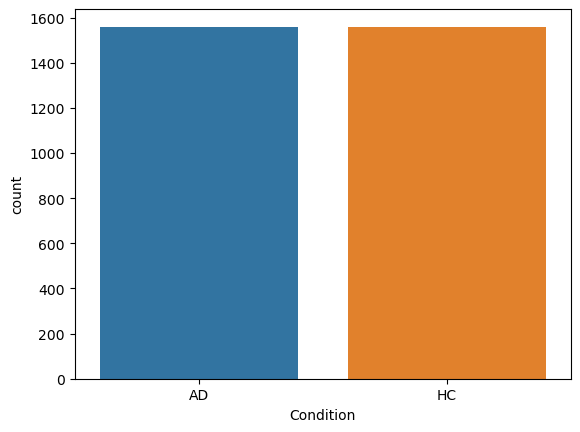

In [94]:
sns.countplot(df_usampling["Condition"])

In [95]:
# Binary enconding 
Y = df_usampling["Condition"].to_numpy()

l_encoder = LabelEncoder()
i_encoded = l_encoder.fit_transform(Y)

Y = i_encoded.reshape(1, -1).T
labels = set(df["Condition"])
labels

{'AD', 'HC'}

In [96]:
# Train and Test splitting 
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.2, random_state=0)

#X_train, X_val, y_train, y_val = train_test_split(   
#     X_train, y_train, test_size=0.1, random_state=42)

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


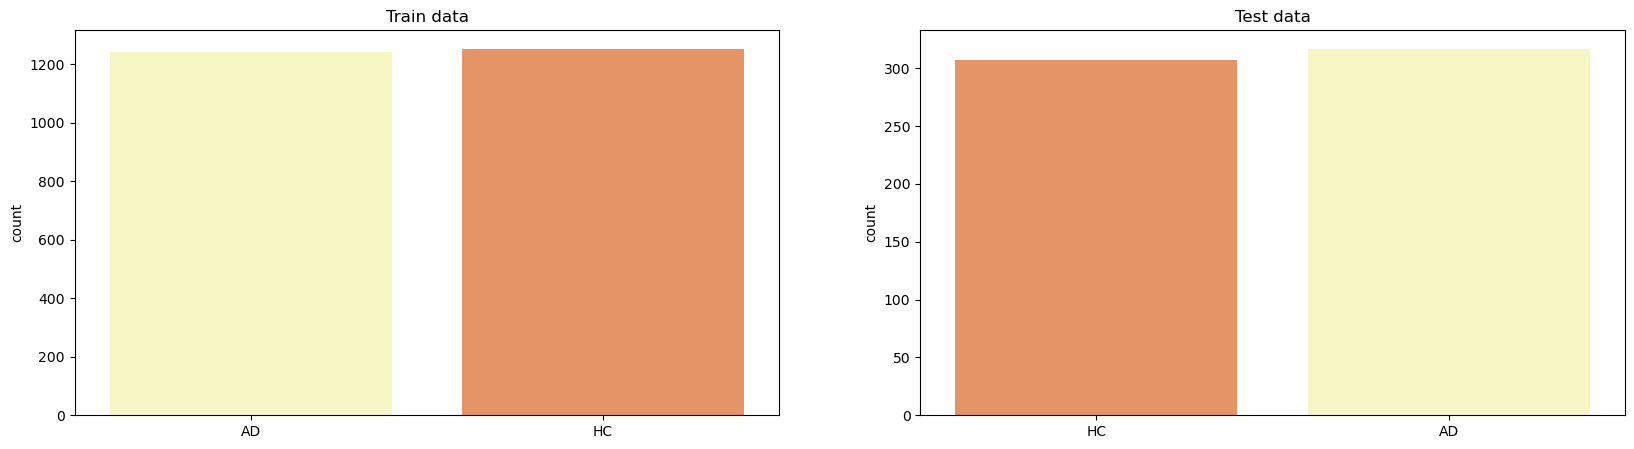

In [97]:
colors = sns.color_palette('Spectral', 3)
palette = {mode: color for mode, color in zip(labels, colors)}

fig, ax = plt.subplots(1,2,figsize=(20,5))


sns.countplot(l_encoder.inverse_transform(y_train.ravel()), ax=ax[0], palette=palette)
ax[0].set_title("Train data")

sns.countplot(l_encoder.inverse_transform(y_test.ravel()), ax=ax[1], palette=palette);
ax[1].set_title("Test data");

# Models

## Support Vector Machine 

In [98]:
X_train_reshape = X_train.reshape(X_train.shape[0],400)
X_test_reshape = X_test.reshape(X_test.shape[0],400)

In [99]:
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1000], 'gamma': [0.1], 'kernel': ['rbf']}  #{'C': [1,10,100,1000], 'gamma': [0.01, 0.001, 0.0001],'kernel': ['rbf']}

grid = GridSearchCV(SVC(random_state=125),param_grid,refit=True, return_train_score=True)
grid.fit(X_train_reshape,y_train.ravel())

GridSearchCV(estimator=SVC(random_state=125),
             param_grid={'C': [1000], 'gamma': [0.1], 'kernel': ['rbf']},
             return_train_score=True)

In [100]:
grid.best_params_

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

0.9310897435897436


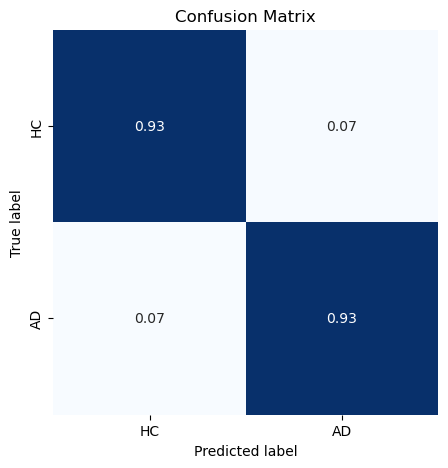

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       317
           1       0.93      0.93      0.93       307

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



In [101]:
y_pred=grid.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))

class_report, fig = showClassficationReport(y_pred , y_test.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_SVM_test.png".format(time_window, frequency, preprocessing))


0.9927884615384616


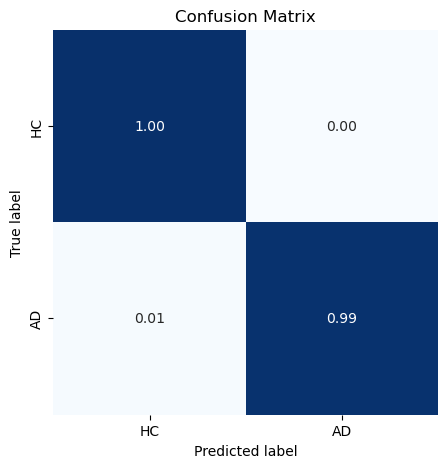

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1243
           1       1.00      0.99      0.99      1253

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496



In [102]:
y_pred=grid.predict(X_train_reshape)

print(accuracy_score(y_train, y_pred))

class_report, fig = showClassficationReport(y_pred , y_train.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_SVM_train.png".format(time_window, frequency, preprocessing))


## Random Forest

In [31]:
# Random forest 
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [1, 2, 5, 10, 20, 80], 'max_features': [2, 3, 5, 10],'n_estimators': [1, 2, 3, 5, 10, 30, 50, 100, 200, 300, 500]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=125),param_grid,refit=True, return_train_score=True)
grid_rf.fit(X_train_reshape,y_train.ravel())

GridSearchCV(estimator=RandomForestClassifier(random_state=125),
             param_grid={'max_depth': [1, 2, 5, 10, 20, 80],
                         'max_features': [2, 3, 5, 10],
                         'n_estimators': [1, 2, 3, 5, 10, 30, 50, 100, 200, 300,
                                          500]},
             return_train_score=True)

In [32]:
grid_rf.best_params_

{'max_depth': 20, 'max_features': 10, 'n_estimators': 500}

0.8958333333333334


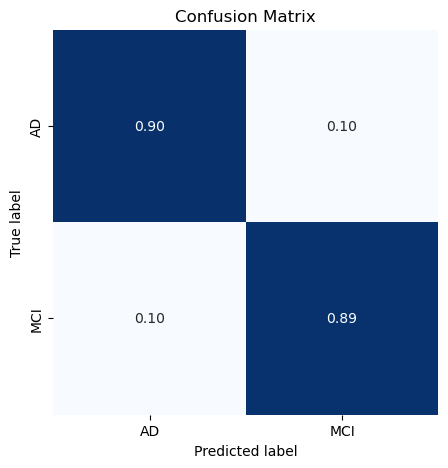

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       317
           1       0.90      0.89      0.89       307

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



In [33]:
y_pred=grid_rf.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))

class_report, fig = showClassficationReport(y_pred , y_test.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_RF_test.png".format(time_window, frequency, preprocessing))


1.0


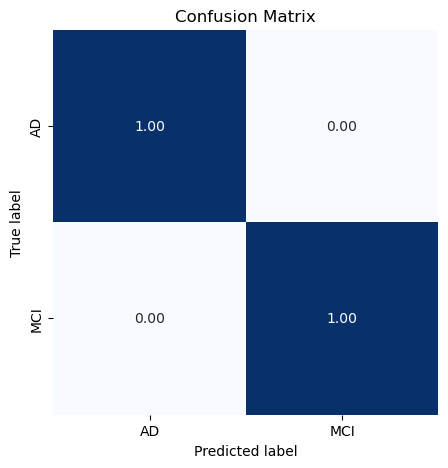

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1243
           1       1.00      1.00      1.00      1253

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496



In [34]:
y_pred=grid_rf.predict(X_train_reshape)

print(accuracy_score(y_train, y_pred))

class_report, fig = showClassficationReport(y_pred , y_train.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_RF_train.png".format(time_window, frequency, preprocessing))


## MLP 

In [43]:
from sklearn.neural_network import MLPClassifier

parameter_space = {
    'hidden_layer_sizes': [(128,128,64)],
    'activation': ['relu'],
    'solver': ['lbfgs',],
    'alpha': [0.001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [ 0.01]}

clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_reshape, y_train) # X is train samples and y is the corresponding labels

c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.001],
                         'hidden_layer_sizes': [(128, 128, 64)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.01], 'solver': ['lbfgs']})

0.8766025641025641


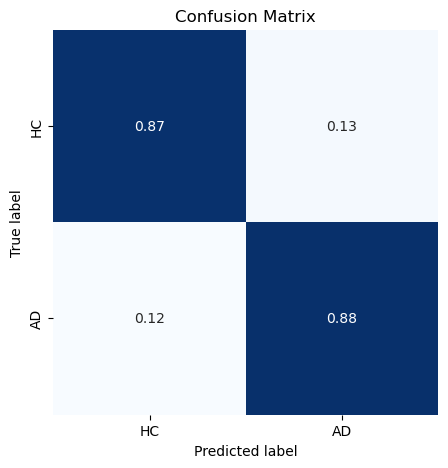

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       317
           1       0.87      0.88      0.88       307

    accuracy                           0.88       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



In [44]:
y_pred=clf.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))

class_report, fig = showClassficationReport(y_pred , y_test.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_MLP_test.png".format(time_window, frequency, preprocessing))


0.8894230769230769


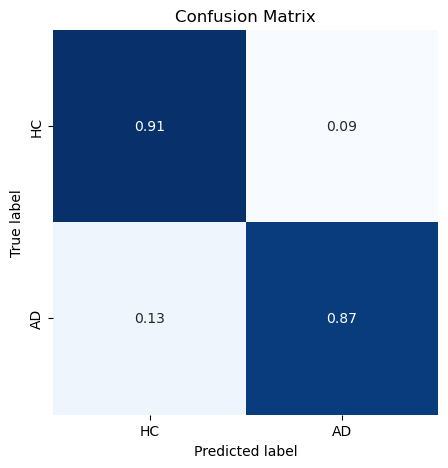

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       419
           1       0.90      0.87      0.89       413

    accuracy                           0.89       832
   macro avg       0.89      0.89      0.89       832
weighted avg       0.89      0.89      0.89       832



In [32]:
y_pred=clf.predict(X_train_reshape)

print(accuracy_score(y_train, y_pred))

class_report, fig = showClassficationReport(y_pred , y_train.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_MLP_train.png".format(time_window, frequency,preprocessing))


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)


param_grid =   { 'n_neighbors' : list(range(1,2)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']}

grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True, return_train_score=True)

grid_knn.fit(X_train_reshape,y_train.ravel())


In [20]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

0.9022435897435898


c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


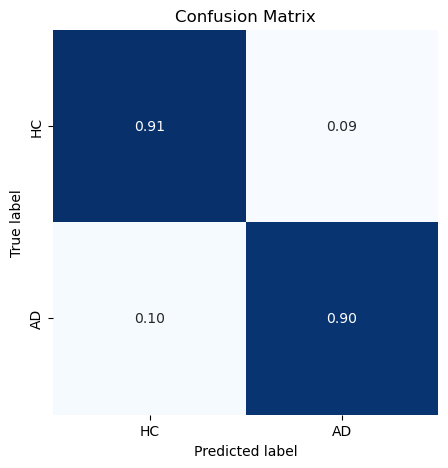

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       317
           1       0.90      0.90      0.90       307

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



In [21]:
y_pred=grid_knn.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))

class_report, fig = showClassficationReport(y_pred , y_test.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_KNN_test.png".format(time_window, frequency, preprocessing))


1.0


c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


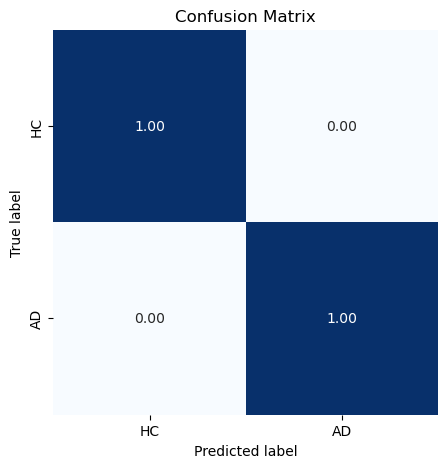

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1243
           1       1.00      1.00      1.00      1253

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496



In [45]:
y_pred=grid_knn.predict(X_train_reshape)

print(accuracy_score(y_train, y_pred))

class_report, fig = showClassficationReport(y_pred , y_train.T[0], labels)
print(class_report)

fig.savefig("./Results/images/{}_{}_{}_KNN_train.png".format(time_window, frequency, preprocessing))


## Deep Neural Network

In [103]:
X = Variable(torch.from_numpy(X.astype(np.float32)), requires_grad=False)
Y = Variable(torch.from_numpy(Y.astype(np.float32)), requires_grad=False)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.3, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(   
#     X_train, y_train, test_size=0.1, random_state=42)

In [105]:
data_dist = {"train" : len(X_train), "test" : len(X_test) } #, "val" : len(X_val)}
data_dist

{'train': 2184, 'test': 936}

In [106]:
# Network Initialization 

model = nn.Sequential(
          nn.Conv2d(1,16,3),
          nn.Conv2d(16,16,3),
          nn.MaxPool2d(2),
          nn.Dropout(),
          nn.Conv2d(16,32,3),
          nn.Conv2d(32,32,3),
          nn.MaxPool2d(3),
          nn.Dropout(),
          nn.Flatten(),
          nn.Linear(32, 160),
          nn.Dropout(),
          nn.Linear(160, 1),
          nn.Sigmoid()
        )
model.to("cuda")

#summary(model, (1,20,20))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=32, out_features=160, bias=True)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=160, out_features=1, bias=True)
  (12): Sigmoid()
)

In [107]:
batch_size = 64
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
validation_ds = torch.utils.data.TensorDataset(X_test, y_test)


train_ds_loader = torch.utils.data.DataLoader(train_ds,shuffle=True, batch_size=64)
val_ds_loader = torch.utils.data.DataLoader(validation_ds,shuffle=True, batch_size=936)

In [108]:
for d1, l1 in val_ds_loader:
    print(l1.shape)



torch.Size([936, 1])


In [109]:
import torch.optim as optim
import copy



loss_fn=nn.BCELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [110]:
num_epoch = 300 
train_losses=[]
valid_losses=[]

# Hold the best model
best_acc = - np.inf   # init to negative infinity
best_weights = None

In [112]:
num_epoch = 300
for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0
  train_f1 = []
  train_acc = []

  model.train()
  for img,lbl in train_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    optimizer.zero_grad()
    predict=model(img.view(img.shape[0],1,20,20))
    loss=loss_fn(predict,lbl)
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    train_acc.append(accuracy_score(label, prediction.round())) 
    train_f1.append(f1_score(label, prediction.round())) 


  train_loss=train_loss/len(train_ds_loader.sampler) 
  valid_loss=valid_loss/len(val_ds_loader.sampler)
  train_losses.append(train_loss)

  train_acc = np.mean(train_acc)
  train_f1 = np.mean(train_f1)

  # Evaluation 
  model.eval()

  for img,lbl in val_ds_loader: 
    img=img.cuda()
    lbl=lbl.cuda()

    predict=model(img.view(img.shape[0],1,20,20))

    loss=loss_fn(predict,lbl)
    valid_loss =loss.item()*img.size(0)
    valid_losses.append(valid_loss)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    val_acc = accuracy_score(label, prediction.round())
    val_f1 = f1_score(label, prediction.round())
  
    if(val_acc + val_f1 > best_acc):
      best_acc = val_acc + val_f1
      best_weights = copy.deepcopy(model.state_dict())
    if(val_acc + val_f1 >= 2 ):
      best_weights = copy.deepcopy(model.state_dict())
      print(l1.shape)
      print(showClassficationReport(label, prediction.round(), ["AD", "HC"]))
      break

  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} Train Accuracy:{:.4f} Train F1:{:.4f} Valid Accuracy:{:.4f} Valid F1:{:.4f} best_acc {:.4f}'.format(epoch,train_loss,valid_loss, train_acc, train_f1, val_acc, val_f1, best_acc)) 

Epoch:1 Train Loss:0.3343 valid Losss:270.0144 Train Accuracy:0.8442 Train F1:0.8438 Valid Accuracy:0.8697 Valid F1:0.8610 best_acc 1.8247
Epoch:2 Train Loss:0.3440 valid Losss:242.7655 Train Accuracy:0.8469 Train F1:0.8442 Valid Accuracy:0.9017 Valid F1:0.9013 best_acc 1.8247
Epoch:3 Train Loss:0.3279 valid Losss:256.6113 Train Accuracy:0.8496 Train F1:0.8499 Valid Accuracy:0.8771 Valid F1:0.8655 best_acc 1.8247
Epoch:4 Train Loss:0.3341 valid Losss:246.4888 Train Accuracy:0.8504 Train F1:0.8492 Valid Accuracy:0.9060 Valid F1:0.9050 best_acc 1.8247
Epoch:5 Train Loss:0.3155 valid Losss:250.8494 Train Accuracy:0.8540 Train F1:0.8562 Valid Accuracy:0.8974 Valid F1:0.8963 best_acc 1.8247
Epoch:6 Train Loss:0.3369 valid Losss:260.9764 Train Accuracy:0.8473 Train F1:0.8327 Valid Accuracy:0.8835 Valid F1:0.8749 best_acc 1.8247
Epoch:7 Train Loss:0.3459 valid Losss:259.5936 Train Accuracy:0.8451 Train F1:0.8453 Valid Accuracy:0.8900 Valid F1:0.8847 best_acc 1.8247
Epoch:8 Train Loss:0.3383 v

<AxesSubplot:>

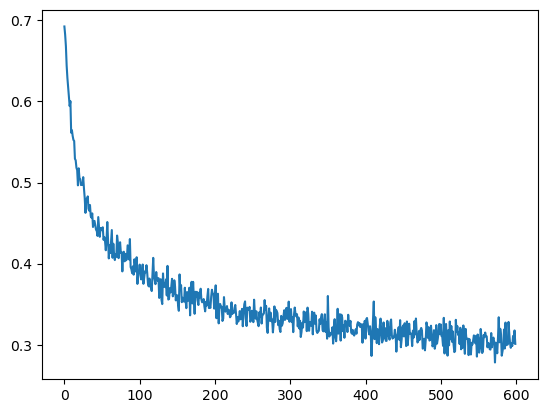

In [113]:
train_losses
sns.lineplot(x=range(len(train_losses)), y=train_losses)

<AxesSubplot:>

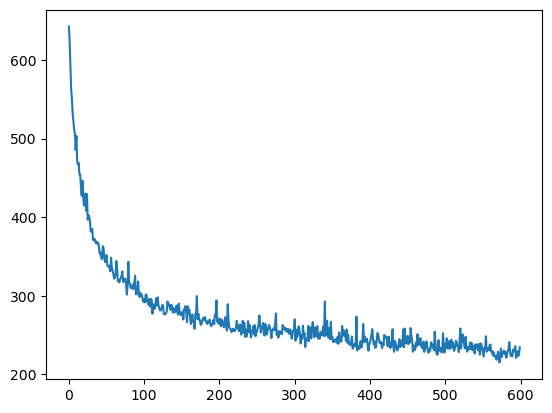

In [114]:
sns.lineplot(x=range(len(valid_losses)), y=valid_losses)

In [115]:
best_weights_copy = best_weights

In [116]:
model.load_state_dict(best_weights)

<All keys matched successfully>

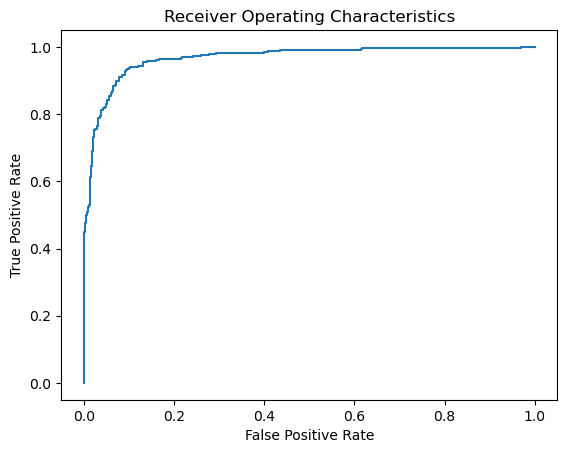

In [120]:
with torch.no_grad():
    # Plot the ROC curve
    img,lbl in val_ds_loader
    y_pred = model(img.view(img.shape[0],1,20,20))
    fpr, tpr, thresholds = roc_curve(lbl.cpu(), y_pred.cpu())
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

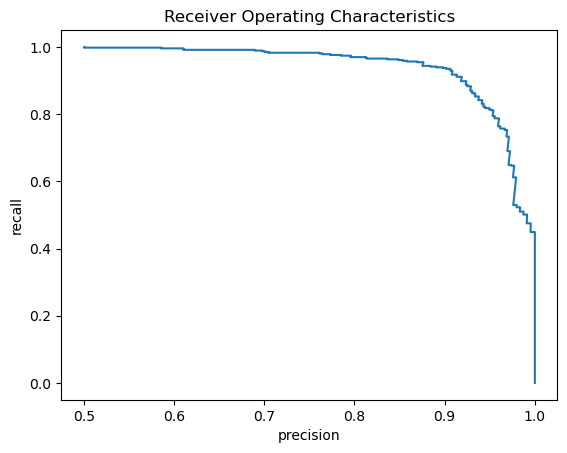

In [121]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve




with torch.no_grad():
    # Plot the ROC curve
    img,lbl in val_ds_loader
    y_pred = model(img.view(img.shape[0],1,20,20))
    fpr, tpr, thresholds = precision_recall_curve(lbl.cpu(), y_pred.cpu())
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()

In [122]:
f1 = (2*fpr*tpr)/(fpr+tpr)

threashold = f1.argmax()

thresholds[threashold]

f1[threashold]

0.919957310565635

In [123]:
fpr[threashold]

0.9054621848739496

In [124]:
thresholds[threashold]

0.5295753

In [125]:
model.cuda()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=32, out_features=160, bias=True)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=160, out_features=1, bias=True)
  (12): Sigmoid()
)

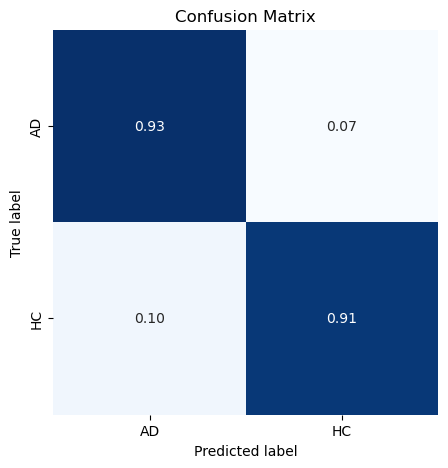

('              precision    recall  f1-score   support\n\n       False       0.91      0.93      0.92       461\n        True       0.93      0.91      0.92       475\n\n    accuracy                           0.92       936\n   macro avg       0.92      0.92      0.92       936\nweighted avg       0.92      0.92      0.92       936\n', <Figure size 500x500 with 1 Axes>)


In [126]:
img,lbl in val_ds_loader
y_pred = model(img.view(img.shape[0],1,20,20)).cpu().detach().numpy()

y_pred = y_pred >  thresholds[threashold]# 0.5

print(showClassficationReport(lbl.cpu(), y_pred, ["AD", "HC"]))


In [86]:
val_acc = accuracy_score(lbl.cpu(), y_pred.round())
val_f1 = f1_score(lbl.cpu(), y_pred.round())

print(val_acc, val_f1)

0.9145299145299145 0.9141630901287554


In [322]:
len(y_pred)

16

In [320]:
lbl.cpu()

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])

In [141]:
torch.save(model.state_dict(), "Model/5sec_f1_0.89.model")

# Average matrices

In [434]:
hc_idx = list(np.where(df_usampling["Condition"] == "HC")[0])
ad_idx = list(np.where(df_usampling["Condition"] == "AD")[0])

In [435]:
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [436]:
for i in hc_idx: 
    corr_hc += X[i]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += X[i]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

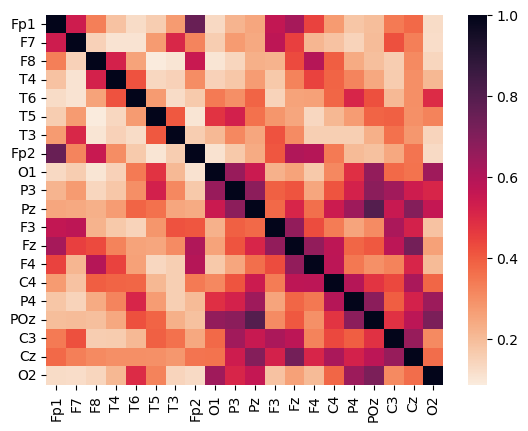

In [445]:
cmap = sns.cm.rocket_r

sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

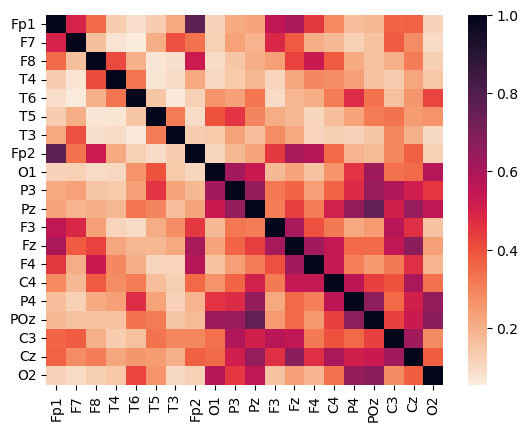

In [446]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

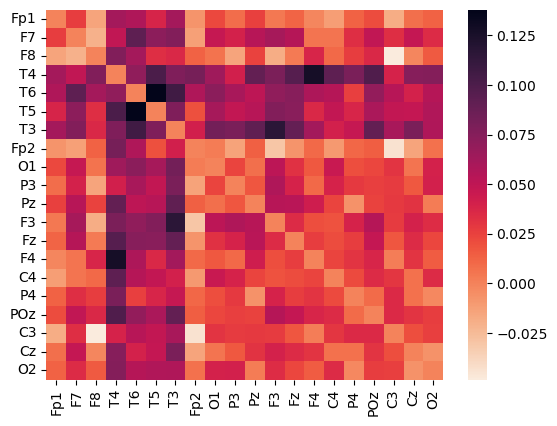

In [448]:
sns.heatmap((corr_hc-corr_ad), cmap=cmap, xticklabels=channels, yticklabels=channels)